# Charge density profiles

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import openmm
from openmm import app
from openmm import unit

import mdtraj

In [2]:
field = '../c2mim_bf4_gr/equil/field.xml'
config = '../c2mim_bf4_gr/equil/config.pdb'
dcd = '../c2mim_bf4_gr/run/traj.dcd'

Import trajectory

In [3]:
trj = mdtraj.load(dcd, top=config)

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


In [4]:
z_n = trj.xyz[:, :, 2]
nframes, natoms = z_n.shape
print (nframes, 'frames', natoms, 'atoms')

2000 frames 9920 atoms


Obtain charges from an OpenMM system

In [5]:
pdb = app.PDBFile(config)
forcefield = app.ForceField(field)

In [6]:
system = forcefield.createSystem(pdb.topology)

In [7]:
charges = np.zeros(natoms)

for force in system.getForces():
    if isinstance(force, openmm.NonbondedForce):
        for i in range(natoms):
            q, sig, eps = force.getParticleParameters(i)
            charges[i] = q.value_in_unit(unit.elementary_charge)
        break

In [8]:
print("Total charge:", charges.sum())

Total charge: 1.4210854715202004e-14


Define bins along z

In [9]:
zmin = z_n.min()
zmax = z_n.max()

nbins = 200
bins = np.linspace(zmin, zmax, nbins + 1)
dz = bins[1] - bins[0]
bin_mid = 0.5 * (bins[:-1] + bins[1:])      # mid points of bins

print('zmin =', zmin, 'zmax =', zmax, 'dz =', dz, unit.nanometer)

zmin = 0.87992316 zmax = 7.4821014 dz = 0.0330109 nanometer


Charge profile

In [10]:
qz = np.zeros(nbins)

for frame in range(nframes):
    z = z_n[frame]

    ibin = np.digitize(z, bins) - 1             # returns bin indices for each z
    valid = (ibin >= 0) & (ibin < nbins)        # only within range

    np.add.at(qz, ibin[valid], charges[valid])  # accumulate charges in qz

qz /= nframes                                   # average over frames

In [11]:
box_x = trj.unitcell_lengths[:, 0].mean()
box_y = trj.unitcell_lengths[:, 1].mean()

bin_vol = box_x * box_y * dz
rho = qz / bin_vol  # e nm-3

In [12]:
rho_SI = rho * 1.602176634e-19 * 1e27  # C m-3

Charge neutrality

In [13]:
np.trapezoid(rho_SI, bin_mid*1e-9)

np.float64(-1.5845064539644904e-06)

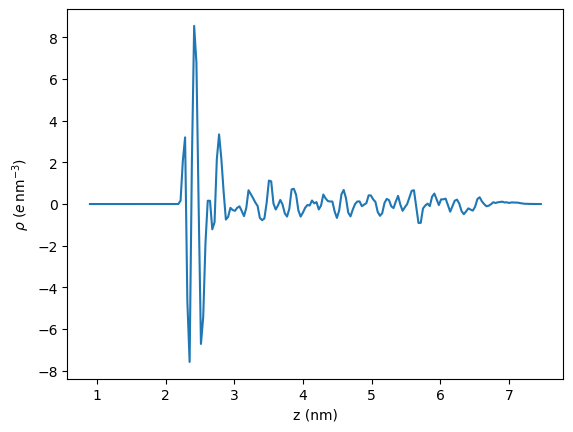

In [14]:
plt.plot(bin_mid, rho)
plt.xlabel(r"z (nm)")
plt.ylabel(r"$\rho\ (e\,\mathrm{nm}^{-3})$")
plt.show()

In [ ]:
def integrate_rho(bin_mid, rho_SI):
    """
    Integrate charge density to obtain potential.
    
    phi(z) = - 1/eps0 int_{-L}^z (z - z') rho(z') dz'
    """
    eps0 = 8.854187817e-12  # F / m
    z = bin_mid * 1e-9      # m
    dz = z[1] - z[0]
    phi = np.zeros_like(rho_SI)

    for i, zi in enumerate(z):
        integrand = rho_SI[:i] * (zi - z[:i])
        phi[i] = - np.sum(integrand) * dz / eps0

    return phi

In [49]:
def integrate_rho(bin_mid, rho_SI):
    """
    Integrate charge density to obtain potential.
    
    phi(z) = - 1/eps0 [ z int_-L^z rho(z') dz' - int_-L^z z' rho(z') dz' ]
    """
    eps0 = 8.854187817e-12  # F / m
    z = bin_mid * 1e-9      # m
    dz = z[1] - z[0]

    Q = np.cumsum(rho_SI) * dz                # ∫ rho dz'
    ZQ = np.cumsum(z * rho_SI) * dz           # ∫ z' rho dz'

    phi = -(z * Q - ZQ) / eps0
    return phi

In [50]:
phi = integrate_rho(bin_mid, rho_SI)

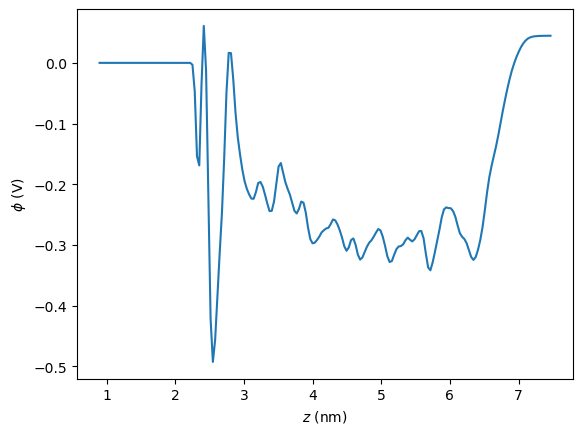

In [ ]:
plt.plot(bin_mid, phi)
plt.xlabel(r"$z$ (nm)")
plt.ylabel(r"$\phi\ (\mathrm{V})$")
plt.show()